In [1]:
from sklearn.cluster import KMeans
import numpy as np
import nsepy
import datetime
import ta
import pandas as pd
from pandas_datareader import data
import random

In [2]:
X=pd.read_csv('bob.csv')
X

,Date,High,Low,Open,Close,Volume,Adj Close
0,2012-01-02,134.020004,130.669998,134.020004,133.639999,621765.0,82.026894
1,2012-01-03,140.979996,134.389999,134.389999,140.050003,1308700.0,85.961281
2,2012-01-04,142.000000,138.259995,140.979996,140.210007,1515265.0,86.059494
3,2012-01-05,141.570007,137.729996,140.399994,138.919998,2718015.0,85.267693
4,2012-01-06,141.000000,136.639999,137.000000,140.449997,923805.0,86.206802
...,...,...,...,...,...,...,...
1881,2019-08-26,99.900002,91.500000,99.900002,95.050003,43374486.0,95.050003
1882,2019-08-27,99.199997,96.650002,97.000000,97.300003,35349172.0,97.300003
1883,2019-08-28,97.650002,93.750000,97.199997,94.500000,24947200.0,94.500000
1884,2019-08-29,96.000000,91.349998,94.000000,91.800003,28470571.0,91.800003


In [3]:
def data1():
    X=pd.read_csv('bob.csv')
    X['c-o']=(X.Close-X.Open)/X.Open*100
    X['candle']=np.where(X['c-o'].values<-2,0,np.where(X['c-o'].values<-1,1,np.where(X['c-o'].values<0,2,np.where(X['c-o'].values<1,3,np.where(X['c-o'].values<2,4,5))))) #This line updates the value of candle column based on the value of corresponding c-o. If c-o <2 it is 4 else it is 5. if c-o<1 it is 3 else it goes to previous condition and so on.
    X = X.dropna(axis = 0, how ='any') #drop rows with missing values meaning if row has 'any ' empty values drop it
    X = X.reset_index()
    X = X.reset_index()
    X['cash']=0
    X['action']=""
    X['action1']=""
    return X

In [4]:
X=data1()
X

,level_0,index,Date,High,Low,Open,Close,Volume,Adj Close,c-o,candle,cash,action,action1
0,0,0,2012-01-02,134.020004,130.669998,134.020004,133.639999,621765.0,82.026894,-0.283543,2,0,,
1,1,1,2012-01-03,140.979996,134.389999,134.389999,140.050003,1308700.0,85.961281,4.211626,5,0,,
2,2,2,2012-01-04,142.000000,138.259995,140.979996,140.210007,1515265.0,86.059494,-0.546169,2,0,,
3,3,3,2012-01-05,141.570007,137.729996,140.399994,138.919998,2718015.0,85.267693,-1.054128,1,0,,
4,4,4,2012-01-06,141.000000,136.639999,137.000000,140.449997,923805.0,86.206802,2.518246,5,0,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1881,1881,1881,2019-08-26,99.900002,91.500000,99.900002,95.050003,43374486.0,95.050003,-4.854853,0,0,,
1882,1882,1882,2019-08-27,99.199997,96.650002,97.000000,97.300003,35349172.0,97.300003,0.309281,3,0,,
1883,1883,1883,2019-08-28,97.650002,93.750000,97.199997,94.500000,24947200.0,94.500000,-2.777775,0,0,,
1884,1884,1884,2019-08-29,96.000000,91.349998,94.000000,91.800003,28470571.0,91.800003,-2.340422,0,0,,


In [5]:
def getState(t):    
    return(X['candle'][t]) 

In [10]:
class Agent:
    def __init__(self):
        self.epsilon = 1.0 #Value of  epsilon to denote we are exploring as much as possible
        self.gamma = 0.618 #Discount factor decided as 0.618
        self.epsilon_decay = 0.995 #rate at which epsilon decays as we reach optimal solution.
        self.epsilon_min = 0.01 #minimum value epsilon should take
        self.Q1 = np.matrix(np.zeros([6,3])) #6 states and 3 actions for each state initial Q table entries are zero.
        self.Q2= np.matrix(np.zeros([6,3]))
        self.learning_rate=0.03 #parameter used in Q-learning equation.
        
    def getAction(self,state):
        a=[1,0,2]
        if np.random.rand() <= self.epsilon: #compares random numbers between -1 to 1 to epsilon value at that point of time.
            return random.choice(a)#if true, choose a random value of a.
        else:
            if np.random.rand()<=0.5:
                return np.argmax(self.Q1[state,])  #else, choose the action with highest state value 1-epsilon times(acc to epsilon greedy algo)
            else:
                return np.argmax(self.Q2[state,]) 
    # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
    def update(self,state,action,reward,next_state,next_action):
        if np.random.rand()<=0.5:
            self.Q1[state,action]= self.Q1[state,action] + self.learning_rate * (reward + self.gamma * np.max(self.Q2[next_state, :])
                                                                - self.Q1[state,action])
        else:
            self.Q2[state,action]= self.Q2[state,action] + self.learning_rate * (reward + self.gamma * np.max(self.Q1[next_state, :])
                                                                - self.Q2[state,action])

In [11]:
episode_count=200
agent=Agent()
agent.Q1
agent.Q2
m1=0
m2=0
for e in range(1,episode_count+1):
    X=data1()  #updated data entry   
    data_length_start=1
    data_length=1419
    agent.epsilon=1
    state = getState(data_length_start) #get state X['candle'][1] always here meaning initial state is always 3 initially.
    action = agent.getAction(state) #based on that state, we select action of state 3 having max.reward 1-epsilon times and random action e times.
    last_action=None #for first state of the episode last action NULL.
    last_price=0
    last_quantity=0
    capital=X.loc[data_length_start,'Open']*100 #Initial capital at start of episode. based on the entry at 1st  row.
    margin=X.loc[data_length_start,'Open']*100  #initial margin
    brok_rate=0.0010 
    profit=0    #no profit at start of episode.
    print("Episod {}/{}".format(e,episode_count))
    count=0
    for t in range(data_length_start,data_length-1): #from 1 to 4577 possible states in each episode.
        #print('t',t)        
        reward=0 #reward for each action taken =0.
        if last_action=='sold': #if last action taken (in previous time step) is 'sold'
            tbrokerage=(X.loc[t,'Close']+last_price)*brok_rate  #brokerage charges 
            tprofit=(last_price-X.loc[t,'Close'])*last_quantity #profit made by selling the quantities at the new time step -remember the last action is taken on this time step.
            tprofit1=(tprofit/(last_price*last_quantity))*100 #calculating the profit % based on price at whic stock was bought.
             
            if tprofit1<-10: #if loss is too high i.e less tha  10%
                profit=profit+tprofit #always this is the new profit updating for each episode - we only see profit/loss when we sell
                margin=margin+(last_quantity*last_price)+(tprofit) #updating the margin
                X.loc[t,'cash']=margin      #denotes the min.amount investor must pay for security.
                #print('close short stop loss @',X['Open'].iloc[t])
                last_action=None # change the last action
                X.loc[t,'action']="close short" #close the shorting position
                X.loc[t,'action1']="long" #start your long position on the stock.
                reward= max((np.log(last_price)-np.log(X.loc[t,'Open'])),0) #updating the reward as a logarithmic difference b/w buying price and selling price if loss is made else 0 for profit- reward for closing a short position. 0 reward for taking such an action since it was suboptimal.
        elif last_action=='bought':#if your action was to buy the stock
            tbrokerage=(X.loc[t,'Close']+last_price)*brok_rate #update broker fee always fixed.
            tprofit=(X.loc[t,'Close']-last_price)*last_quantity #profit 
            tprofit1=(tprofit/(last_price*last_quantity))*100
            if tprofit1<-10: #incase you had bought the stock and now currently losses is more than 10% we will close our long positionon the stock and bet the stock goes down.
                profit=profit+tprofit
                margin=margin+(last_quantity*last_price)+(tprofit)
                X.loc[t,'cash']=margin        
                #print('close long stop loss @',X.loc[t,'Open'])
                last_action=None
                X.loc[t,'action']="close long"
                X.loc[t,'action1']="short"
                reward= max((np.log(X.loc[t,'Open'])-np.log(last_price+tbrokerage)),0)      #reward will be 0 in this case for taking sub-optimal action.            
                          
            
        if action == 1  and last_action==None : #generally the first encountered loop here -for the first state in the episode. action==1 means long position - algo is by default optimistic price will go up.
            #print('in long')
            X.loc[t,'cash']=margin      #update the value of that entry of X['cash'] to margin.     MARGIN= HOW MUCH CASH YOU HAVE TO SPEND. 
            last_quantity=margin//X.loc[t,'Close']  #number of stocks owned based on the money you had / closing price of stock for that particular time step- the quotient basically.
            margin=margin%X.loc[t,'Close'] #remaining cash after having bought the last_quantity number of stocks. 
            last_price=X.loc[t,'Close'] #price of last stock bought updated.
            last_action='bought'#to denote we have bought a stock.
            #print('open long @',last_price)
            X.loc[t,'action']="open long" #A long—or a long position—refers to the purchase of an asset with the expectation it will increase in value—a bullish attitude.We are betting the stock price will increase-this action of betting bullishly is open long
            X.loc[t,'action1']="long" #Betting bullishly.
            count=count+1 #Count of buys?
        elif action == 1  and last_action=='sold':
            #print('in close short')
            tbrokerage=(X.loc[t,'Close']+last_price)*brok_rate #Whenever your last action was buy or sell -we have to pay brokerage fee.
            tprofit=(last_price-X.loc[t,'Close']-tbrokerage)*last_quantity #profit made or loss .
            tprofit1=(tprofit/(last_price*last_quantity))*100 #percent of profit.
            if  tprofit>10 or tprofit1<-5: #if profit was more than 3% or loss was also more than 3%
                profit=profit+tprofit #profit update
                margin=margin+(last_quantity*last_price)+(tprofit) #Cash in hand
                X.loc[t,'cash']=margin      #update cash in hand as margin -negative if we were in loss.
                #print('close short @',X.loc[t,'Open'])
                last_action=None # we wont take any action.
                X.loc[t,'action']="close short" #in this scenario we always go long if we were shorting -bettng stock goes up.
                X.loc[t,'action1']="long" #new position.
                reward= max((np.log(last_price)-np.log(X.loc[t,'Close']+tbrokerage)),0) #0 for loss positive valeu for profit.
            else:
                tp=(last_price-X.loc[t,'Close'])*last_quantity
                original=margin+(last_quantity*last_price)
                X.loc[t,'cash']=original+tp   #Else while updating the cash in hand we wont change our position-if we were shorting we continue shorting.
                
        elif action == 1  and last_action=='bought':
            #print('in hold long')
            X.loc[t,'cash']=margin+(last_quantity*X.loc[t,'Close']) #updating cash in hand to buy/sell stock.
        elif action == 2  and last_action==None and margin>X.loc[t,'Close']:#Say this is the first time step and your margin> closing price -Meaning the value of stock has gone down after that day of trading- so we short it-bet it will fall more.
            #print('in short')
            X.loc[t,'cash']=margin #your updated margin - cash in hand.        
            last_quantity=margin//X.loc[t,'Close']# you bought these number of stocks.
            margin=margin%X.loc[t,'Close']#remaining cash.
            last_price=X.loc[t,'Close']#price of last bought stock.
            last_action='sold'        #last action taken is 'sold'
            #print('open short @',last_price)
            X.loc[t,'action']="open short" #we wll bet that stock goes down. we are shorting our position and we get profit if stock goes down.
            X.loc[t,'action1']="short"   #this action is a subset of shorting pisition taken by agent.   
            count=count+1 #update the count of no. of time steps we bought the stock. Only difference here is we shorted the stock.
        elif action == 2 and  last_action=='bought':#close long ->previous time step we bought the stock and action==2 represents we are shorting. So if last action was to buy the stock(long ) we have to close our long position.
            #print('in close long')
            tbrokerage=(X.loc[t,'Close']+last_price)*brok_rate #this denotes the brokerage fee to be paid for having bought the stock previously 
            tprofit=(X.loc[t,'Close']-last_price-tbrokerage)*last_quantity #Denotes the profit made after brokerage fee has been deducted.
            tprofit1=(tprofit/(last_price*last_quantity))*100 #% profit made (% of previous time step margin)
            if tprofit1>10 or tprofit1<-5: #if a profit of 3% or more was made or a  loss of 3% or less was made
                profit=profit+tprofit # update the profit from the episode.
                margin=margin+(last_quantity*last_price)+(tprofit) #update the margin meaning new money in hand or money in debt.
                X.loc[t,'cash']=margin        #update the cash in hand at time step to be margin.
                #print('close long @',X.loc[t,'Open'])
                last_action=None
                X.loc[t,'action']="close long" #close long position and we start to short.
                X.loc[t,'action1']="short"# action comes under the shorting position.
                reward= max((np.log(X.loc[t,'Close'])-np.log(last_price+tbrokerage)),0) #denote choosing reward as 0 or the logarithmic difference between close price at which you sold -log(last_price +broker fee) based on which is higher(in loss means reward=0))
            else:
                X.loc[t,'cash']=margin+(last_quantity*X.loc[t,'Close']) #update the cash at that time step to be margin + cash in hand after selling the last_qauntity stocks.
                
            
        elif action == 2  and last_action=='sold': #in a shorting position and you have also taken last action to be sold.
            #print('in hold short')
            tp=(last_price-X.loc[t,'Close'])*last_quantity # amount of profit lossed or loss made.
            original=margin+(last_quantity*last_price) # margin of cash in hand.
            X.loc[t,'cash']=original+tp #this is the net cash in hand taking into consideration the profits missed or losses saved.
        else:            
            if last_action==None: 
                X.loc[t,'cash']=margin #cash in hand is margin itself 
                #print('in hold1')
            elif last_action=='bought':
                X.loc[t,'cash']=margin+(last_quantity*X.loc[t,'Close'])  #
                #print('in hold2')
            elif last_action=='sold':
                tp=(last_price-X.loc[t,'Close'])*last_quantity
                original=margin+(last_quantity*last_price)
                X.loc[t,'cash']=original+tp     
                #print('in hold3')
                                       
              
        next_state=getState(t+1)
        next_action=agent.getAction(next_state)
        agent.update(state,action,reward,next_state,next_action)
        state=next_state
        action=next_action
        
        if t==data_length-2:
                print("--------------------------------")
                if  last_action=='sold':
                    tbrokerage=(X.loc[t,'Close']+last_price)*brok_rate
                    tprofit=(last_price-X.loc[t,'Close']-tbrokerage)*last_quantity
                    profit=profit+tprofit
                    margin=margin+(last_quantity*last_price)+(tprofit) 
                    X.loc[t,'cash']=margin
                    #print('close short @',X.loc[t,'Close'])
                    last_action=None
                    X.loc[t,'action']="close short"
                    X.loc[t,'action1']="long"
                elif last_action=='bought':
                    tbrokerage=(X.loc[t,'Close']+last_price)*brok_rate
                    tprofit=(X.loc[t,'Close']-last_price-tbrokerage)*last_quantity
                    profit=profit+tprofit
                    margin=margin+(last_quantity*last_price)+(tprofit) 
                    X.loc[t,'cash']=margin
                    #print('close long @',X.loc[t,'Close'])
                    last_action=None
                    X.loc[t,'action']="close long"
                    X.loc[t,'action1']="short"
                print("\n***********************")
                print("Profit is ",profit)
                print("Initial Capital is ",capital)    
                print("Current Capital is ",margin)
                roi=((margin-capital)/capital)*100
                print("%ROI is ",roi)
                bnh=((X.loc[t,'Close']-X.loc[data_length_start,'Close'])/X.loc[data_length_start,'Close'])*100
                print("% Buy and Hold=",bnh)
                print("count",count)
                print("qtable1",agent.Q1)
                print("qtable2",agent.Q2)
                print("epsilon",agent.epsilon)
                print("--------------------------------")
                       
        if (agent.epsilon > agent.epsilon_min) and e>1:
                       agent.epsilon *= agent.epsilon_decay
                       
    
    m3=roi
    if m3>m2:
        m1=e
        m2=m3
    #To save model            
    np.save('C:\Python\RL PROJECT CODE\IMPROVEMENT-MODEL2\MODEL2-TRAIN\QTable1/Qtable1'+ str(e)+str('.npy'), agent.Q1)
    np.save('C:\Python\RL PROJECT CODE\IMPROVEMENT-MODEL2\MODEL2-TRAIN\QTable2/Qtable2'+ str(e)+str('.npy'), agent.Q2)
    np.save('C:\Python\RL PROJECT CODE\IMPROVEMENT-MODEL2\MODEL2-TRAIN\Epsilon/epsilon'+ str(e)+str('.npy'), agent.epsilon)
    np.save('C:\Python\RL PROJECT CODE\IMPROVEMENT-MODEL2\MODEL2-TRAIN\Gamma/gamma'+ str(e)+str('.npy'), agent.gamma)
    np.save('C:\Python\RL PROJECT CODE\IMPROVEMENT-MODEL2\MODEL2-TRAIN\Learning_Rate/learning_rate'+ str(e)+str('.npy'), agent.learning_rate)
    X.to_csv('C:\Python\RL PROJECT CODE\IMPROVEMENT-MODEL2\MODEL2-TRAIN\AfterTrain/AfterTrain'+str(e)+str('.csv'))
print("e={},roi={}".format(m1,m2))

Episod 1/200
--------------------------------

***********************
Profit is  -8154.460979606622
Initial Capital is  13438.999938964844
Current Capital is  5284.538959358226
%ROI is  -60.677587741954596
% Buy and Hold= -0.32131163044377464
count 100
qtable1 [[0.00146511 0.00502025 0.00435432]
 [0.00149343 0.00342187 0.00168644]
 [0.00168652 0.00286725 0.00609844]
 [0.00189782 0.00209318 0.00334386]
 [0.0013757  0.0013974  0.00148681]
 [0.00150802 0.00256323 0.01593108]]
qtable2 [[0.00134208 0.00406668 0.00101962]
 [0.00161968 0.00226802 0.00478457]
 [0.00125864 0.00400574 0.00137769]
 [0.00110778 0.00198606 0.00493374]
 [0.00080068 0.00143873 0.00783879]
 [0.00102259 0.00120314 0.01574382]]
epsilon 1
--------------------------------
Episod 2/200
--------------------------------

***********************
Profit is  5682.524052619964
Initial Capital is  13438.999938964844
Current Capital is  19121.523991584803
%ROI is  42.283831225745686
% Buy and Hold= -0.32131163044377464
count 138


--------------------------------

***********************
Profit is  29138.72967028042
Initial Capital is  13438.999938964844
Current Capital is  42577.72960924526
%ROI is  216.82215791813496
% Buy and Hold= -0.32131163044377464
count 124
qtable1 [[0.00512573 0.01095923 0.00889103]
 [0.00491644 0.00704932 0.00524567]
 [0.00515189 0.00540057 0.00538592]
 [0.00460516 0.00554689 0.00790002]
 [0.00386786 0.00384755 0.00584046]
 [0.00456736 0.00383703 0.02206908]]
qtable2 [[0.00502074 0.00870149 0.0051864 ]
 [0.0044728  0.00641572 0.00548599]
 [0.00503323 0.00525842 0.00535585]
 [0.00479282 0.00469748 0.00776159]
 [0.00427192 0.00347379 0.00613969]
 [0.00438362 0.0045418  0.01927136]]
epsilon 0.00998645168764533
--------------------------------
Episod 13/200
--------------------------------

***********************
Profit is  -2444.851066169744
Initial Capital is  13438.999938964844
Current Capital is  10994.148872795096
%ROI is  -18.19220981675267
% Buy and Hold= -0.32131163044377464
count

Episod 23/200
--------------------------------

***********************
Profit is  -5283.429202346789
Initial Capital is  13438.999938964844
Current Capital is  8155.570736618057
%ROI is  -39.31415452297227
% Buy and Hold= -0.32131163044377464
count 116
qtable1 [[0.00575987 0.00658376 0.0062893 ]
 [0.00569217 0.00653413 0.00597914]
 [0.00478099 0.00483842 0.00511041]
 [0.00492899 0.00533551 0.00582223]
 [0.00500229 0.0056602  0.00528401]
 [0.00483153 0.00520984 0.01486139]]
qtable2 [[0.00569398 0.00745733 0.00601104]
 [0.0054371  0.00561166 0.00547681]
 [0.00505608 0.00526912 0.00492314]
 [0.00534884 0.00550108 0.00925216]
 [0.00443702 0.00487328 0.00507874]
 [0.00469245 0.00457753 0.0192541 ]]
epsilon 0.00998645168764533
--------------------------------
Episod 24/200
--------------------------------

***********************
Profit is  9052.63727874756
Initial Capital is  13438.999938964844
Current Capital is  22491.63721771241
%ROI is  67.36094441447597
% Buy and Hold= -0.321311630443

--------------------------------

***********************
Profit is  10407.988622367877
Initial Capital is  13438.999938964844
Current Capital is  23846.98856133273
%ROI is  77.44615424984946
% Buy and Hold= -0.32131163044377464
count 101
qtable1 [[0.00585763 0.00833443 0.00617574]
 [0.00532607 0.00708796 0.00527444]
 [0.00488941 0.00455037 0.0048949 ]
 [0.00456131 0.00510557 0.00433428]
 [0.00475212 0.0048033  0.00601253]
 [0.00469235 0.00532159 0.02483829]]
qtable2 [[0.00524994 0.00679235 0.0057633 ]
 [0.0055819  0.0056449  0.00613973]
 [0.00474357 0.00511826 0.00448799]
 [0.00469914 0.00466226 0.00485657]
 [0.00495003 0.00525323 0.01008961]
 [0.0045653  0.00462425 0.0148576 ]]
epsilon 0.00998645168764533
--------------------------------
Episod 35/200
--------------------------------

***********************
Profit is  11680.347085205056
Initial Capital is  13438.999938964844
Current Capital is  25119.347024169914
%ROI is  86.91381158012538
% Buy and Hold= -0.32131163044377464
count 

--------------------------------

***********************
Profit is  26334.887517051724
Initial Capital is  13438.999938964844
Current Capital is  39773.88745601653
%ROI is  195.95868469867827
% Buy and Hold= -0.32131163044377464
count 131
qtable1 [[0.006117   0.01006274 0.00582829]
 [0.00593013 0.00715776 0.00531394]
 [0.00532211 0.00441907 0.00564364]
 [0.00485731 0.00499392 0.00784371]
 [0.00465166 0.00433654 0.00650315]
 [0.0049393  0.00508543 0.01299132]]
qtable2 [[0.00556002 0.01239914 0.0057037 ]
 [0.00530284 0.00605128 0.00564454]
 [0.00476963 0.004875   0.00520264]
 [0.00481903 0.00514425 0.00775936]
 [0.00484464 0.00484308 0.00601163]
 [0.00470902 0.00448388 0.02534787]]
epsilon 0.00998645168764533
--------------------------------
Episod 46/200
--------------------------------

***********************
Profit is  -8959.209531387334
Initial Capital is  13438.999938964844
Current Capital is  4479.790407577506
%ROI is  -66.66574575546454
% Buy and Hold= -0.32131163044377464
count

--------------------------------

***********************
Profit is  8855.620975631691
Initial Capital is  13438.999938964844
Current Capital is  22294.62091459654
%ROI is  65.8949402176559
% Buy and Hold= -0.32131163044377464
count 123
qtable1 [[0.00529477 0.01078331 0.00531956]
 [0.0050728  0.00662852 0.00481326]
 [0.00479792 0.00525705 0.00567564]
 [0.00485977 0.00506419 0.00716757]
 [0.00468303 0.00515642 0.00657271]
 [0.00439559 0.00481453 0.01612876]]
qtable2 [[0.0055759  0.00747865 0.00583416]
 [0.00539089 0.00666657 0.00473052]
 [0.00530432 0.00590978 0.00556453]
 [0.00459108 0.00619797 0.00671188]
 [0.00509392 0.00502909 0.00820047]
 [0.00454309 0.00495278 0.02189226]]
epsilon 0.00998645168764533
--------------------------------
Episod 57/200
--------------------------------

***********************
Profit is  -4585.921400177
Initial Capital is  13438.999938964844
Current Capital is  8853.07853878784
%ROI is  -34.12397813084773
% Buy and Hold= -0.32131163044377464
count 125
qt

--------------------------------

***********************
Profit is  -6475.812594497669
Initial Capital is  13438.999938964844
Current Capital is  6963.187344467174
%ROI is  -48.1867149632302
% Buy and Hold= -0.32131163044377464
count 127
qtable1 [[0.00596561 0.0070345  0.00546819]
 [0.00535201 0.00718474 0.00545813]
 [0.00523261 0.0052527  0.00534001]
 [0.00473814 0.00497162 0.00739129]
 [0.00533075 0.00518168 0.00570198]
 [0.00523841 0.00455084 0.01564855]]
qtable2 [[0.00526663 0.01114138 0.00625056]
 [0.00514134 0.00535569 0.00518742]
 [0.0046898  0.00509782 0.00523736]
 [0.00476811 0.00469461 0.00564591]
 [0.00469997 0.00496963 0.00554157]
 [0.00437594 0.00549732 0.01890044]]
epsilon 0.00998645168764533
--------------------------------
Episod 68/200
--------------------------------

***********************
Profit is  3998.5951984329076
Initial Capital is  13438.999938964844
Current Capital is  17437.59513739775
%ROI is  29.75366631887123
% Buy and Hold= -0.32131163044377464
count 1

--------------------------------

***********************
Profit is  -2737.090595367435
Initial Capital is  13438.999938964844
Current Capital is  10701.909343597415
%ROI is  -20.36677288338656
% Buy and Hold= -0.32131163044377464
count 132
qtable1 [[0.00584137 0.00575761 0.0053188 ]
 [0.00467909 0.00723797 0.0070954 ]
 [0.00473883 0.00554849 0.00515713]
 [0.0052115  0.00475818 0.00948978]
 [0.00478198 0.00509189 0.00511511]
 [0.0053409  0.00480237 0.01146326]]
qtable2 [[0.00600639 0.00751297 0.0067703 ]
 [0.00517122 0.00774742 0.00478124]
 [0.00479274 0.00535834 0.00501668]
 [0.00477511 0.0044636  0.00491819]
 [0.00472697 0.0050298  0.0081012 ]
 [0.00452413 0.00503835 0.02643557]]
epsilon 0.00998645168764533
--------------------------------
Episod 79/200
--------------------------------

***********************
Profit is  -5001.9516633071835
Initial Capital is  13438.999938964844
Current Capital is  8437.048275657666
%ROI is  -37.219671746590244
% Buy and Hold= -0.32131163044377464
co

--------------------------------

***********************
Profit is  -4544.339009391795
Initial Capital is  13438.999938964844
Current Capital is  8894.660929573056
%ROI is  -33.81456231885229
% Buy and Hold= -0.32131163044377464
count 130
qtable1 [[0.00577908 0.00746301 0.00623439]
 [0.00590728 0.00671915 0.00524787]
 [0.00469492 0.00562686 0.00543122]
 [0.00505098 0.00512073 0.00570193]
 [0.00501378 0.00493206 0.0061952 ]
 [0.00502824 0.00494759 0.01467034]]
qtable2 [[0.00576347 0.01079344 0.00752017]
 [0.00556137 0.005999   0.00599537]
 [0.00489167 0.00471525 0.00502344]
 [0.00480926 0.00544297 0.00910572]
 [0.00500166 0.00479021 0.0052233 ]
 [0.00499468 0.00511723 0.02199388]]
epsilon 0.00998645168764533
--------------------------------
Episod 90/200
--------------------------------

***********************
Profit is  2088.204865966787
Initial Capital is  13438.999938964844
Current Capital is  15527.204804931638
%ROI is  15.538394787191592
% Buy and Hold= -0.32131163044377464
count

--------------------------------

***********************
Profit is  6113.904585586536
Initial Capital is  13438.999938964844
Current Capital is  19552.904524551388
%ROI is  45.493746657889155
% Buy and Hold= -0.32131163044377464
count 124
qtable1 [[0.00561975 0.00823758 0.00577984]
 [0.00564963 0.00649266 0.00553468]
 [0.00486784 0.00694176 0.00521639]
 [0.00532457 0.00494558 0.0054989 ]
 [0.00491165 0.00496446 0.00783002]
 [0.00487934 0.00543278 0.01194156]]
qtable2 [[0.00616428 0.0065846  0.00678815]
 [0.00474817 0.00634135 0.00606246]
 [0.00494106 0.00666402 0.00503237]
 [0.00516822 0.00628492 0.0065739 ]
 [0.0051925  0.00520455 0.00838742]
 [0.00517482 0.00538476 0.01793084]]
epsilon 0.00998645168764533
--------------------------------
Episod 101/200
--------------------------------

***********************
Profit is  230.00274864957845
Initial Capital is  13438.999938964844
Current Capital is  13669.002687614422
%ROI is  1.7114573234181778
% Buy and Hold= -0.32131163044377464
cou

--------------------------------

***********************
Profit is  8318.374424621594
Initial Capital is  13438.999938964844
Current Capital is  21757.374363586452
%ROI is  61.89727258278671
% Buy and Hold= -0.32131163044377464
count 123
qtable1 [[0.00558705 0.00976127 0.0056637 ]
 [0.00535123 0.00708214 0.00520337]
 [0.00469442 0.00470359 0.00465128]
 [0.00509791 0.0048056  0.0053691 ]
 [0.00482899 0.00510885 0.01007773]
 [0.00513852 0.00567872 0.01668354]]
qtable2 [[0.00508275 0.00574184 0.00583352]
 [0.00555397 0.00756158 0.00582979]
 [0.00469392 0.00485414 0.00516693]
 [0.00482886 0.00505925 0.00498499]
 [0.00495803 0.00540978 0.00967157]
 [0.00443835 0.0051226  0.01715202]]
epsilon 0.00998645168764533
--------------------------------
Episod 112/200
--------------------------------

***********************
Profit is  -4779.704896369937
Initial Capital is  13438.999938964844
Current Capital is  8659.295042594911
%ROI is  -35.565926914782736
% Buy and Hold= -0.32131163044377464
coun

--------------------------------

***********************
Profit is  3293.9277148056162
Initial Capital is  13438.999938964844
Current Capital is  16732.927653770457
%ROI is  24.510214523145034
% Buy and Hold= -0.32131163044377464
count 119
qtable1 [[0.00535698 0.00920443 0.00577212]
 [0.00537747 0.00667744 0.00510696]
 [0.0049699  0.00557058 0.0051916 ]
 [0.00466197 0.00529488 0.00935275]
 [0.00454343 0.00491626 0.00587055]
 [0.00475428 0.00453342 0.01445009]]
qtable2 [[0.0055464  0.00873466 0.00590928]
 [0.00503253 0.00577956 0.00526665]
 [0.0047638  0.00559373 0.00514691]
 [0.00482381 0.00431204 0.00558041]
 [0.00482095 0.00465153 0.00567492]
 [0.00437548 0.00516042 0.02549221]]
epsilon 0.00998645168764533
--------------------------------
Episod 123/200
--------------------------------

***********************
Profit is  -12101.82864133454
Initial Capital is  13438.999938964844
Current Capital is  1337.1712976303047
%ROI is  -90.05006842991844
% Buy and Hold= -0.32131163044377464
co

--------------------------------

***********************
Profit is  -10316.724626205438
Initial Capital is  13438.999938964844
Current Capital is  3122.2753127593996
%ROI is  -76.76705612813703
% Buy and Hold= -0.32131163044377464
count 126
qtable1 [[0.00565142 0.00649907 0.00574395]
 [0.00548308 0.00576915 0.00524922]
 [0.00431657 0.00487756 0.00473378]
 [0.00479318 0.00488121 0.00571505]
 [0.0044943  0.00467861 0.01316896]
 [0.00448645 0.00476117 0.01262565]]
qtable2 [[0.0045702  0.0100409  0.00533599]
 [0.00476368 0.00647942 0.00543471]
 [0.0049616  0.00484253 0.00416475]
 [0.00442223 0.00478276 0.00682929]
 [0.00451483 0.00471486 0.00539017]
 [0.0042781  0.00480333 0.01078703]]
epsilon 0.00998645168764533
--------------------------------
Episod 134/200
--------------------------------

***********************
Profit is  -1513.8585033645568
Initial Capital is  13438.999938964844
Current Capital is  11925.141435600286
%ROI is  -11.264666346007623
% Buy and Hold= -0.32131163044377464

Episod 144/200
--------------------------------

***********************
Profit is  13257.184700744621
Initial Capital is  13438.999938964844
Current Capital is  26696.184639709474
%ROI is  98.64710738115966
% Buy and Hold= -0.32131163044377464
count 136
qtable1 [[0.00520104 0.00979506 0.00661845]
 [0.00612504 0.0058672  0.00571208]
 [0.00532038 0.00525736 0.00577608]
 [0.00584061 0.00569853 0.00723648]
 [0.00519678 0.00493296 0.00550067]
 [0.00450737 0.00523248 0.01808129]]
qtable2 [[0.00508557 0.0114783  0.00585499]
 [0.00580249 0.00710986 0.00520323]
 [0.00512343 0.00559316 0.00558536]
 [0.0048253  0.00558561 0.00551986]
 [0.00502363 0.00518266 0.0096328 ]
 [0.00510194 0.00591469 0.01605506]]
epsilon 0.00998645168764533
--------------------------------
Episod 145/200
--------------------------------

***********************
Profit is  10338.137070884726
Initial Capital is  13438.999938964844
Current Capital is  23777.137009849568
%ROI is  76.92638676863506
% Buy and Hold= -0.3213116

--------------------------------

***********************
Profit is  -10404.93345281219
Initial Capital is  13438.999938964844
Current Capital is  3034.066486152655
%ROI is  -77.42342064192049
% Buy and Hold= -0.32131163044377464
count 114
qtable1 [[0.00515053 0.00693841 0.00536926]
 [0.00490507 0.00488151 0.00506107]
 [0.00448461 0.00454629 0.00428231]
 [0.00465934 0.00466202 0.00458714]
 [0.00464361 0.00470105 0.00727925]
 [0.00466385 0.00476496 0.01378715]]
qtable2 [[0.00567494 0.00680205 0.00592347]
 [0.00491678 0.00568564 0.0050734 ]
 [0.00450174 0.00443063 0.00462375]
 [0.00407663 0.00403929 0.0084241 ]
 [0.0046087  0.00501063 0.00556651]
 [0.00424288 0.00470098 0.01388437]]
epsilon 0.00998645168764533
--------------------------------
Episod 156/200
--------------------------------

***********************
Profit is  -8705.823393203711
Initial Capital is  13438.999938964844
Current Capital is  4733.176545761132
%ROI is  -64.78029193200732
% Buy and Hold= -0.32131163044377464
coun

--------------------------------

***********************
Profit is  1707.2437445602518
Initial Capital is  13438.999938964844
Current Capital is  15146.243683525092
%ROI is  12.703651702611369
% Buy and Hold= -0.32131163044377464
count 117
qtable1 [[0.00519124 0.00797577 0.00623263]
 [0.0047923  0.00590345 0.00551275]
 [0.00494899 0.00536706 0.00758032]
 [0.00459201 0.00490517 0.00453301]
 [0.00490991 0.00468282 0.01058283]
 [0.00507125 0.00475236 0.01608411]]
qtable2 [[0.00550235 0.00753212 0.00670758]
 [0.00624376 0.0065699  0.00641621]
 [0.00477894 0.00491791 0.00510711]
 [0.00484857 0.00515236 0.00456699]
 [0.00487293 0.00507559 0.0062839 ]
 [0.00526117 0.00456424 0.01804736]]
epsilon 0.00998645168764533
--------------------------------
Episod 167/200
--------------------------------

***********************
Profit is  -9004.683770690894
Initial Capital is  13438.999938964844
Current Capital is  4434.316168273948
%ROI is  -67.00412092854353
% Buy and Hold= -0.32131163044377464
cou

--------------------------------

***********************
Profit is  -3373.3043166427797
Initial Capital is  13438.999938964844
Current Capital is  10065.695622322053
%ROI is  -25.10085818857905
% Buy and Hold= -0.32131163044377464
count 136
qtable1 [[0.00571561 0.01077508 0.00590187]
 [0.00497058 0.0067389  0.00570726]
 [0.00502348 0.00495787 0.00525953]
 [0.00440427 0.00496812 0.00729219]
 [0.00503558 0.00490132 0.00748397]
 [0.00482425 0.0050829  0.01527375]]
qtable2 [[0.00587101 0.0084433  0.00576729]
 [0.00578147 0.00751899 0.00532566]
 [0.00482056 0.00548828 0.005617  ]
 [0.00485707 0.00566274 0.00546793]
 [0.00504356 0.00522388 0.00848239]
 [0.00517682 0.00486016 0.01497606]]
epsilon 0.00998645168764533
--------------------------------
Episod 178/200
--------------------------------

***********************
Profit is  15079.051295639054
Initial Capital is  13438.999938964844
Current Capital is  28518.05123460389
%ROI is  112.2036711371585
% Buy and Hold= -0.32131163044377464
cou

--------------------------------

***********************
Profit is  -106.05003775026533
Initial Capital is  13438.999938964844
Current Capital is  13332.949901214588
%ROI is  -0.7891214988607586
% Buy and Hold= -0.32131163044377464
count 103
qtable1 [[0.005639   0.00706928 0.00618479]
 [0.00479394 0.00612422 0.00473586]
 [0.00485832 0.00542606 0.00499019]
 [0.00485736 0.0049402  0.00492998]
 [0.00509077 0.00553208 0.00884071]
 [0.00513092 0.0048208  0.01557064]]
qtable2 [[0.00563797 0.00648395 0.00562491]
 [0.00517681 0.00584359 0.00591337]
 [0.00479783 0.00475881 0.00642454]
 [0.00505641 0.00455127 0.00477564]
 [0.00501699 0.00560895 0.00814536]
 [0.00541864 0.00684134 0.0201204 ]]
epsilon 0.00998645168764533
--------------------------------
Episod 189/200
--------------------------------

***********************
Profit is  -10814.696318328857
Initial Capital is  13438.999938964844
Current Capital is  2624.303620635986
%ROI is  -80.47247836479917
% Buy and Hold= -0.32131163044377464


--------------------------------

***********************
Profit is  -576.5550145568889
Initial Capital is  13438.999938964844
Current Capital is  12862.444924407951
%ROI is  -4.290163086356128
% Buy and Hold= -0.32131163044377464
count 100
qtable1 [[0.00536147 0.00840912 0.00576085]
 [0.00558531 0.00583104 0.0056159 ]
 [0.00494334 0.00487711 0.00498141]
 [0.00529468 0.005451   0.00763381]
 [0.00483378 0.00579602 0.00580812]
 [0.00446939 0.00493994 0.01378897]]
qtable2 [[0.00555908 0.00561264 0.0053062 ]
 [0.00485118 0.00567064 0.00520784]
 [0.00487794 0.00521742 0.00493237]
 [0.0046695  0.00558847 0.00586735]
 [0.00460281 0.00515721 0.00836138]
 [0.00431298 0.00562576 0.02255298]]
epsilon 0.00998645168764533
--------------------------------
Episod 200/200
--------------------------------

***********************
Profit is  -1303.2372134399436
Initial Capital is  13438.999938964844
Current Capital is  12135.762725524895
%ROI is  -9.697427035931156
% Buy and Hold= -0.32131163044377464
c

Populating the interactive namespace from numpy and matplotlib


c:\python\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random', 'e']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


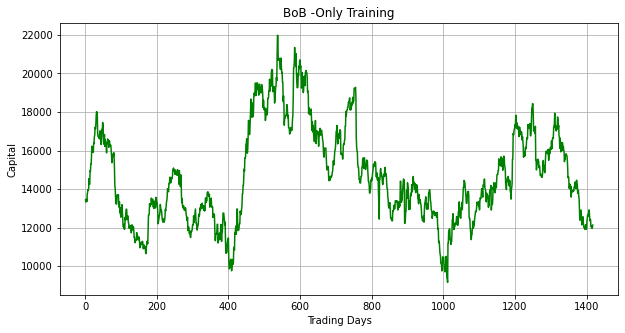

In [12]:
get_ipython().run_line_magic('matplotlib', 'inline')
get_ipython().run_line_magic('pylab', 'inline')
fig = plt.figure()
ax=X.loc[data_length_start:data_length-2,'cash'].plot(grid="True",figsize=(10,5), title='BoB -Only Training',color="g")
ax.set_xlabel("Trading Days")
ax.set_ylabel("Capital")
plt.savefig("IMAGES/BoB-Train-Improvement.png")
plt.show()